In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\libraries')        

from main import *
from FinancialData import *

## Data extraction & Portfolio construction :

In [ ]:
ZCR = ZC_Data_extractor("R:/DR-NATIXIS/ERM/MCRM/LeaderExpert/Stagiaires/2023")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

In [ ]:
nbr_fx =  10
nbr_swap = 600
portfolio = Multi_FX_irs_portfolio( nbr_fx, nbr_swap, first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=list(np.arange(1, 8 + 0.5, 0.5)),
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999)


portfolio.irs_specs

In [4]:
# port_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\portfolio'
# portfolio.save_as_excel(port_path, '\port600irs10fx.xlsx')

## Model parameters & diffusion :

In [4]:
def Random_correlation_matrix(n):
    rho = np.random.uniform(0, 1, (n, n))
    rho = (rho + rho.T) / 2
    np.fill_diagonal(rho, 1)
    rho = np.round(rho, 3)
    return rho
model_params = Model_params(nbr_fx)
cov_matrix = Random_correlation_matrix(2*nbr_fx-1)
model_params.LGM_params, model_params.FX_params, cov_matrix

(array([(0.01262514, 0.02158103), (0.01483993, 0.02395499),
        (0.01679713, 0.01206138), (0.01793371, 0.01358329),
        (0.01612759, 0.01795205), (0.01628393, 0.00724011),
        (0.01504753, 0.01794328), (0.01398726, 0.00824533),
        (0.01847861, 0.00541841), (0.0111421 , 0.0164185 )],
       dtype=[('mean rev', '<f4'), ('sigma', '<f4')]),
 array([(0.        ,), (0.2465949 ,), (0.2789644 ,), (0.23386121,),
        (0.25566685,), (0.22608992,), (0.27535012,), (0.22391306,),
        (0.24992204,), (0.22566737,)], dtype=[('vol', '<f4')]),
 array([[1.   , 0.379, 0.269, 0.359, 0.646, 0.211, 0.873, 0.599, 0.411,
         0.496, 0.67 , 0.071, 0.529, 0.398, 0.274, 0.737, 0.583, 0.661,
         0.238],
        [0.379, 1.   , 0.499, 0.534, 0.683, 0.716, 0.398, 0.398, 0.417,
         0.493, 0.576, 0.72 , 0.744, 0.583, 0.046, 0.605, 0.323, 0.4  ,
         0.697],
        [0.269, 0.499, 1.   , 0.822, 0.425, 0.641, 0.542, 0.249, 0.184,
         0.393, 0.539, 0.714, 0.197, 0.775, 0.09 ,

In [5]:
T = portfolio.last_maturity

tt= time()
diffusion = Multi_FX_Diffusion(0, T, 3000, [ZC for i in range(nbr_fx)], model_params, 10**4, pb_measure='Risk Neutral',
                 cov_matrix= cov_matrix)
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )

# SAVE diffusion
# diff_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\diffusion'
# diffusion.save_as_pickle(diff_path,'\MC10000p600s10f')

Diffusion Time 0:00:55


## CVA calculation : 

In [6]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

In [7]:
time_grid = np.linspace(0,T,20)

mc_start = time()

EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)]) for t in time_grid])
PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
Y = (1-R)*EE*PD
cva = (np.diff(time_grid)*Y[1:]).sum()


NameError: name 'n' is not defined

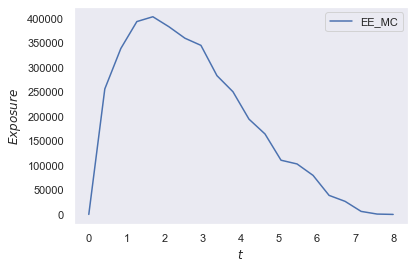

In [8]:
   
plt.plot(time_grid, EE, label="EE_MC")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$Exposure$")
plt.grid(False)


Total Calculation Time : 1:32:15


,Nodes Number,Mtm,CVA MC,time
0,50.0,-75806.79,208.45,198.63
1,100.0,-75806.79,210.42,376.21
2,200.0,-75806.79,210.72,715.17
3,300.0,-75806.79,210.26,1020.56
4,400.0,-75806.79,210.67,1397.28
5,500.0,-75806.79,210.38,1826.06


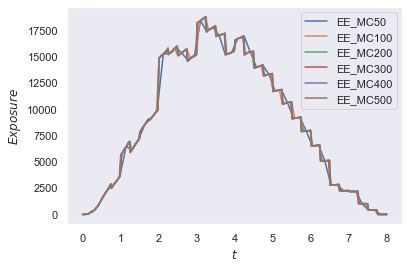

In [21]:
img_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Images'

discretisations = [50,100,200,300,400,500]

mtm = np.mean(portfolio.Mtm(0, diffusion, [ZC for i in range(nbr_fx)]))
benchmark_df =  pd.DataFrame(columns=['Nodes Number', 'Mtm' ,'CVA MC', 'time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()
    
    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)]) for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    benchmark_df.loc[len(benchmark_df)] = [ round(n) , mtm,cva, time() - mc_start]
   
    plt.plot(time_grid, EE, label="EE_MC"+str(n))
    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    #plt.savefig(img_path+'\EE_MC_P600sf10'+'.png')
    plt.show()
    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))
benchmark_df.round(2)

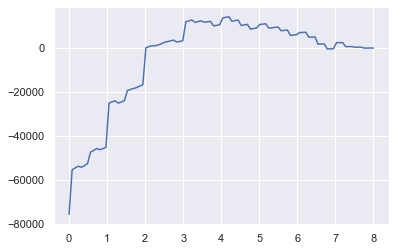

In [24]:
# Plot mtm to see the smothness or get ben hriz portfolio !
mtm_tgrid = np.linspace(0,T,100)
Mtm_mean = np.array([ portfolio.Mtm(t, diffusion, [ZC for i in range(nbr_fx)]).mean() for t in mtm_tgrid])
plt.plot(mtm_tgrid, Mtm_mean)

In [25]:
# # Save Results :
# import pickle
# result_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Full MC'
# with open(result_path+'\EE_MC_P600sf10' ,'wb') as f:
#     pickle.dump(benchmark_df,f)
#     pickle.dump(EE,f)

In [28]:
diffusion.FX_diff[5][6]

array([0.99819471, 0.99760862, 0.99753527, ..., 0.99795499, 0.99704093,
       0.99809733])

In [30]:
Expected_exposure_MC(6, portfolio, diffusion, [ZC for i in range(nbr_fx)])

7981.030832033637